In [1]:
import seaborn
import pandas as pd
import pickle 
from os.path import join
from glob import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import matplotlib_setup
import ntpath
from utils import matplotlib_setup

In [2]:
def cols4vis():
    return ['Flow ID','Dst Port', 'Protocol',
       'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'] # Day is removed, because normal flowid is split seperately per day


In [3]:
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
markers = ['>','*','<','o','^']
LINEWIDTH = 12
MSIZE = 40
MEDGESIZE = 12
csv_gt = 'CSVs_r_1.0_m_1.0'
SEED = 42

In [4]:
K=10
foldname_prefix = '{}fold_'.format(K)
def get_count_per_fold(dataroot): # this makes sure every single malicious example is used(almost)
    fn = join(dataroot,'label_dist.csv')
    df = pd.read_csv(fn, names=['Label','Count'], dtype={'Label':str,'Count':int})
    df = df[df['Label']!='Benign']
    cnt = int(df['Count'].max()) # around 100K 
    return cnt//K


def read_fold0(d):
    if 'WS' in d:
        fn = join(d, 'fold_0.csv')
    else:
        fn = join(d, '10fold_0.csv')
    df = pd.read_csv(fn, usecols=cols4vis())       
    return df


def record2flow(df):
    g_df = df.groupby(['Flow ID','Label'], as_index=False).mean()
    return g_df

def bal_record2flow(df):
    g_df = df.groupby(['Flow ID','Label'], as_index=False).mean()
    ds = g_df.Label.value_counts()
    m = ds[ds.index!='Benign'].max()
    
    g = df.groupby(['Label'], as_index=False, sort=False) # 0.00 sec
    new_df = pd.DataFrame(g.apply(lambda x: x.sample(m, random_state=SEED, replace=True)\
                                  .reset_index(drop=True)))# 33 sec 
    return new_df

In [5]:
id_to_label = {0: 'Benign',
        1: 'DDoS-HOIC',
        2: 'DDoS-LOIC-HTTP',
        3: 'DDoS-LOIC-UDP',
        4: 'DoS-GoldenEye',
        5: 'DoS-Hulk',
        6: 'DoS-SlowHTTPTest',
        7: 'DoS-Slowloris',
        8: 'FTP-BruteForce',
        9: 'Infiltration',
        10: 'SSH-BruteForce',
        11: 'Brute Force-Web',
        12: 'Brute Force-XSS',
        13: 'SQL Injection'
        }
labels = [id_to_label[i] for i in range(len(id_to_label))]

In [6]:

TSNE

NameError: name 'TSNE' is not defined

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')


def visualize(df, fn):
    matplotlib_setup(fontsize=10)
    np.random.seed(SEED)
    rndperm = np.random.permutation(df.shape[0])
    
    observed_cats = [label for label in labels if label in df['y'].unique()]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y", style='y',
    palette=sns.color_palette("hls", df['y'].nunique()),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.9,
    markers = filled_markers,
    s = 100,
    hue_order = observed_cats
    )
    
    plt.savefig(fn)

def pca_vis(df,d):
    y = df.Label.values

    df = df.drop(columns=['Flow ID','Label'])
    X = df.values
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    df_vis = pd.DataFrame()
    df_vis['pca-one'] = result[:,0]
    df_vis['pca-two'] = result[:,1]
    print('y.,shape = ', y.shape)
    df_vis['y'] = y

    visualize(df_vis, join(d,'pca_vis.png'))
    return result

def reduce_dim(df, n):
    new_df = pd.DataFrame()
    new_df['Label'] = df['Label']
    new_df['Flow ID'] = df['Flow ID']
    pca = PCA(n_components=n)
    
    df = df.drop(columns=['Flow ID','Label'])
    result = pca.fit_transform(df.values)
    for d in range(result.shape[1]):
        new_df[str(d)]=result[:,d]
    return new_df
    

def tsna_vis(df,d):
    y = df.Label.values

    df = df.drop(columns=['Flow ID','Label'])
    X = df.values
    tsna = TSNE(n_components=2, verbose=1)
    result = tsna.fit_transform(X)
    
    df_vis = pd.DataFrame()
    df_vis['pca-one'] = result[:,0]
    df_vis['pca-two'] = result[:,1]
    print('y.,shape = ', y.shape)
    df_vis['y'] = y

    visualize(df_vis, join(d,'tsna_vis.png'))


(12645, 80)
y.,shape =  (12645,)


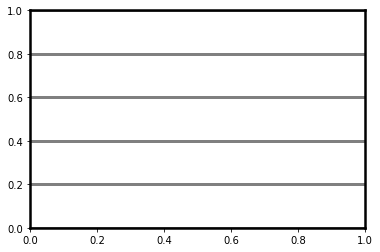

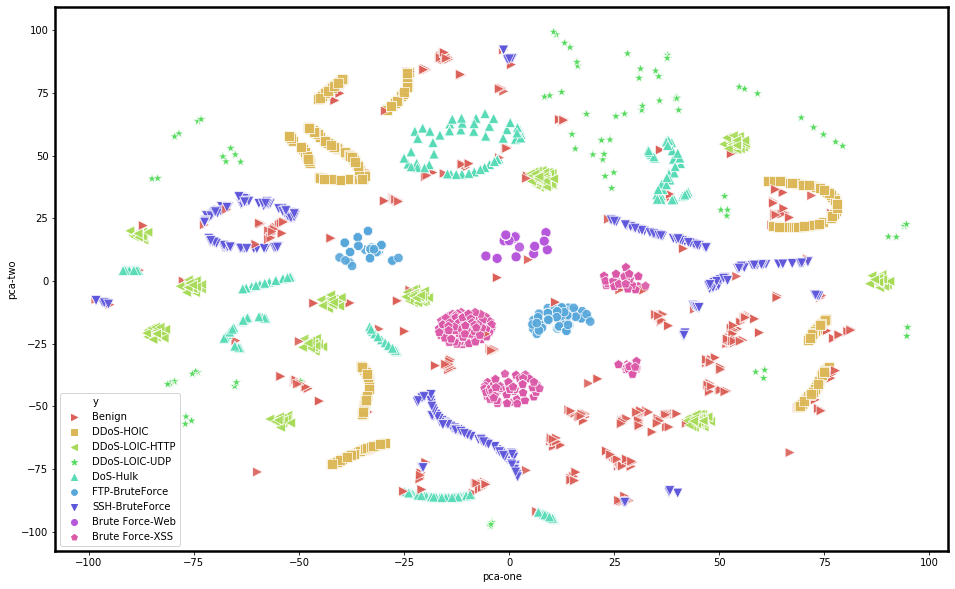

In [14]:
sr_dir = 'SR_0.1'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_n_bal_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        #pca_vis(g_df, sampler_dir)
        tsna_vis(g_df, sampler_dir)

(40749, 80)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40749 samples in 0.069s...
[t-SNE] Computed neighbors for 40749 samples in 1.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40749
[t-SNE] Computed conditional probabilities for sample 2000 / 40749
[t-SNE] Computed conditional probabilities for sample 3000 / 40749
[t-SNE] Computed conditional probabilities for sample 4000 / 40749
[t-SNE] Computed conditional probabilities for sample 5000 / 40749
[t-SNE] Computed conditional probabilities for sample 6000 / 40749
[t-SNE] Computed conditional probabilities for sample 7000 / 40749
[t-SNE] Computed conditional probabilities for sample 8000 / 40749
[t-SNE] Computed conditional probabilities for sample 9000 / 40749
[t-SNE] Computed conditional probabilities for sample 10000 / 40749
[t-SNE] Computed conditional probabilities for sample 11000 / 40749
[t-SNE] Computed conditional probabilities for sample 12000 / 40749
[t-SNE] Computed conditional probabili

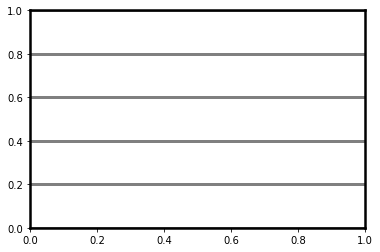

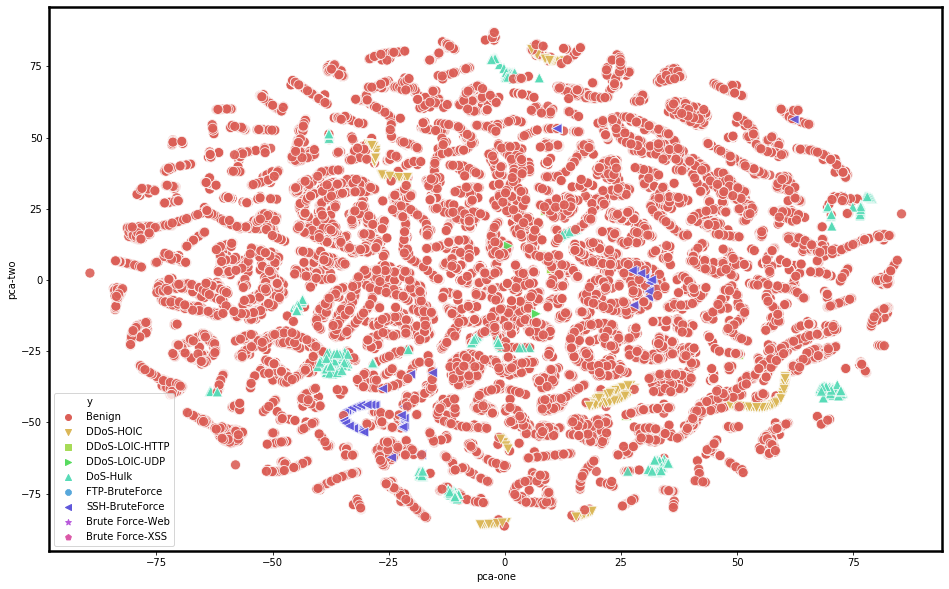

In [15]:
sr_dir = 'SR_0.1'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        g_df = reduce_dim(g_df, n=10)
        tsna_vis(g_df, sampler_dir)

(12645, 80)
y.,shape =  (12645,)


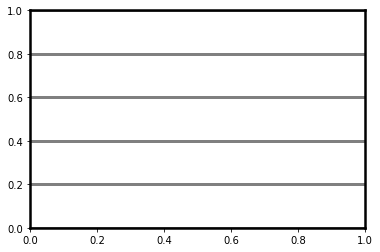

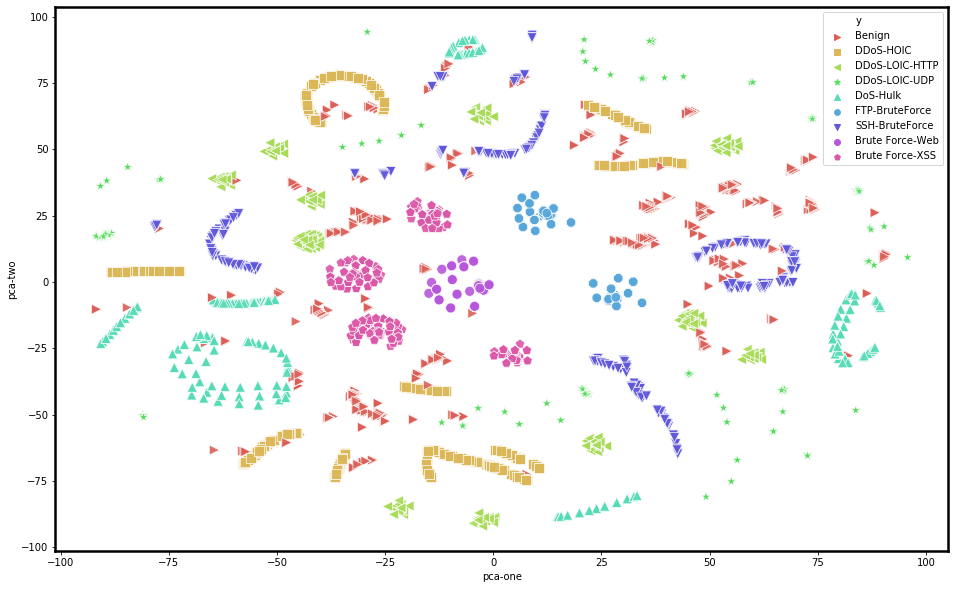

In [15]:
sr_dir = 'SR_0.1'
root = '/data/juma/data/ids18/CSVs_r_0.001_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_n_bal_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        tsna_vis(g_df, sampler_dir)

(122880, 80)
y.,shape =  (122880,)


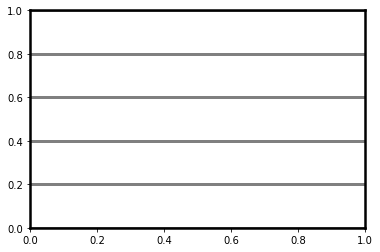

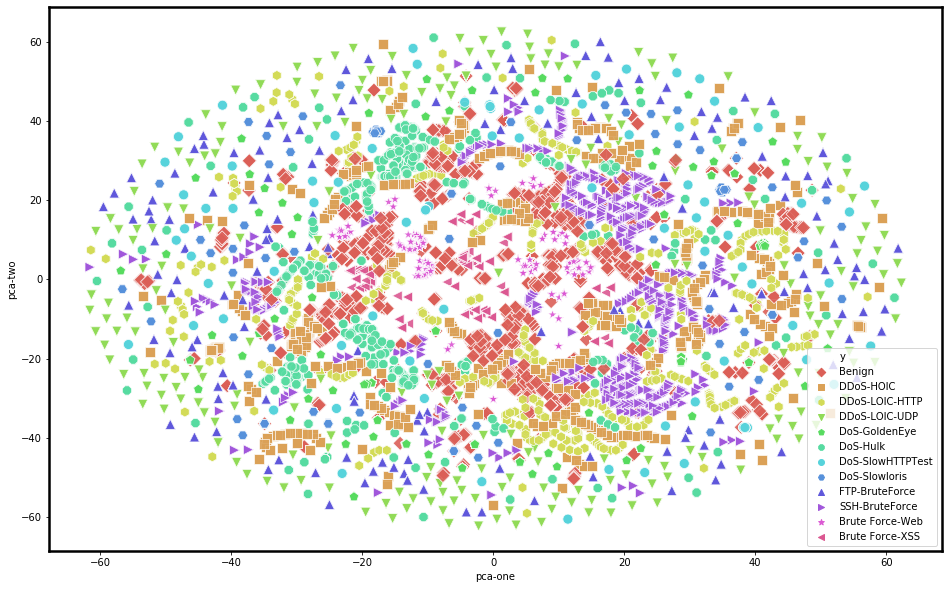

In [16]:
sr_dir = 'SR_1.0'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        g_df = reduce_dim(g_df)
        tsna_vis(g_df, sampler_dir)

In [ ]:
sr_dir = 'SR_1.0'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        tsna_vis(g_df, sampler_dir)

(494792, 80)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 494792 samples in 119.990s...


In [ ]:
sr_dir = 'SR_1.0'
root = '/data/juma/data/ids18/CSVs_r_0.001_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    if 'SFS' in sampler_dir:
        df = read_n_bal_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        tsna_vis(g_df, sampler_dir)

(458500, 80)
y.,shape =  (458500,)


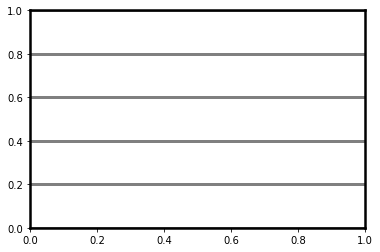

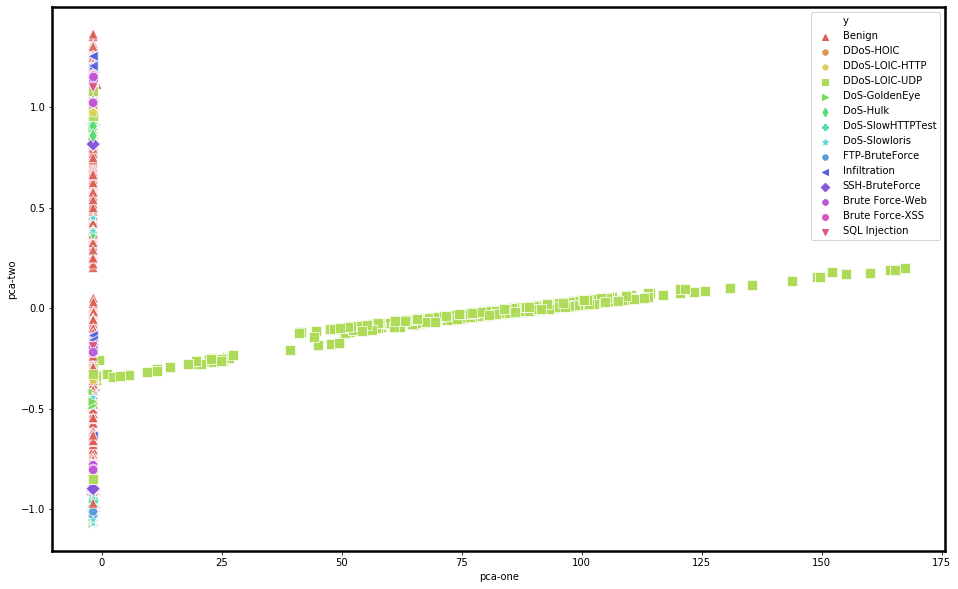

In [133]:
sr_dir = ''
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
        df = read_n_bal_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        pca_vis(g_df, sampler_dir)

In [134]:
sr_dir = ''
root = '/data/juma/data/ids18/CSVs_r_0.001_m_1.0/{}/'.format(sr_dir) 
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
        df = read_n_bal_fold0(sampler_dir)
        g_df = record2flow(df)
        print(g_df.shape)
        pca_vis(g_df, sampler_dir)

MemoryError: Unable to allocate 568. MiB for an array with shape (74431040,) and data type float64